In [1]:
import sys
sys.path.append('C:\\Users\\Максимилиан\\Desktop\\Skoltech\\Reinforcement learning\\Final project')
from casadi import *
%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline
from Dynamics import get_next_state, state_to_coords, get_energy
from Environment import DoublePendulumEnv, normalize_angle
from PPO.Proximal_Policy_Optimization import PPO, unscaled_action
from PPO.train import train

In [2]:
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
import gym
from torch.distributions import Normal
from gym.spaces import Box
import random
from IPython.display import clear_output
from torch.distributions import MultivariateNormal
import numpy as np
from matplotlib import animation
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [43]:
env_name = 'DoubleInvPendulum'
directory = "PPO/PPO3_Trained" + '/' 
checkpoint_path = directory + "PPO_{}_1000K.pth".format(env_name)
print("loading network from : " + checkpoint_path)

loading network from : PPO/PPO3_Trained/PPO_DoubleInvPendulum_1000K.pth


In [44]:
state0 = np.array([0,np.pi/2,np.pi/2,
                0,0,0])
state = state0
state

array([0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        ])

In [45]:
#checkpoint_path = 'PPO_DoubleInvPendulum_0_0.pth'
observation_shape = 6
action_shape = 1
lr_actor = 3e-4  # Learning rate for optimizer of actor network.
lr_critic = 0.001  # Learning rate for optimizer of critic network.
gamma = 0.99
action_std = 0.6  # Initial standard deviation.
action_std_decay_rate = 0.1  # Decay rate of standard deviation.
min_action_std = 0.1  # Threshold standard deviation.
action_std_decay_freq = int(2e5)  # Decay the standard deviation every 2_00_000 timesteps

update_timestep = 5000  # set old_policy parameters to new_policy parameters.
K_epochs = 50  # Number of epochs before updating old policy parameters.
eps_clip = 0.2  # clip range for surrogate loss function.
gamma = gamma  # Discount factor.

In [46]:
agent = PPO(observation_shape,
                action_shape,
                lr_actor,
                lr_critic,
                )

In [47]:
agent.load(checkpoint_path)

In [48]:
state_t = torch.FloatTensor(state)
u = agent.select_action(state_t)
u

array([0.95285505], dtype=float32)

In [49]:
action = unscaled_action(u, action_low = -20, action_high = 20)
dt = 0.02

In [50]:
action

array([19.057102], dtype=float32)

In [51]:
#state = get_next_state(state,action,dt)
state = get_next_state(state,action,dt)
dt

0.02

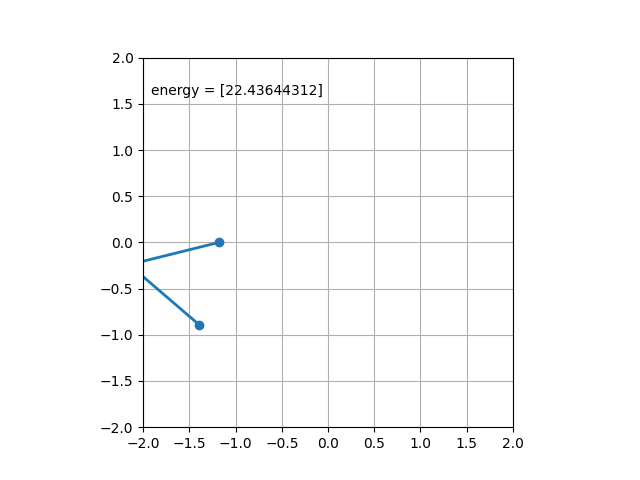

In [52]:
%matplotlib widget

state = state0
dt = 0.02

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line


def animate(i):
    """perform animation step"""
    global state, dt
    state_t = torch.FloatTensor(state)
    action = agent.select_action(state_t)
   # action = unscaled_action(action)
   # print(action)
    state = get_next_state(state,action,dt)
   
    XY = state_to_coords(state)
    
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=300,
                             interval=20, blit=True, init_func=init)


from IPython.display import HTML
HTML(ani.to_jshtml())


In [13]:
env_name = 'One_Pole_InvPendulum'
directory = "1_pole_PPO3_Trained" + '/' 
checkpoint_path = directory + "PPO_{}_100K.pth".format(env_name)
print("loading network from : " + checkpoint_path)
agent.load(checkpoint_path)

loading network from : 1_pole_PPO3_Trained/PPO_One_Pole_InvPendulum_100K.pth


FileNotFoundError: [Errno 2] No such file or directory: '1_pole_PPO3_Trained/PPO_One_Pole_InvPendulum_100K.pth'

In [ ]:

writervideo = animation.FFMpegWriter(fps=60)
anim.save('increasingStraightLine.mp4', writer=writervideo)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.relu = nn.ReLU()
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = self.relu(self.linear1(state))
        x = self.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

In [ ]:
pol_net = PolicyNetwork(6,1,256) # policy_net_init_rew50k (1)

In [ ]:
pol_net.load_state_dict(torch.load('policy_net_init_rew50k (1).pth'))

In [ ]:
%matplotlib widget

state = state0
dt = 0.02

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-5, 5), ylim=(-5, 5))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line


def animate(i):
    """perform animation step"""
    global state, dt
    state_t = torch.FloatTensor(state)
    u = pol_net.get_action(state_t)
    action = u.detach().numpy()
   
    state = get_next_state(state,action,dt)
    XY = state_to_coords(state)
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=500,
                             interval=20, blit=True, init_func=init)

from IPython.display import HTML
HTML(ani.to_jshtml())